# Homework 03 - Machine Learning for Classification

## Dataset


In [1]:
# !wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
sns.set_style("whitegrid")

In [4]:
url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [5]:
df = pd.read_csv(url)
df.sample(3, random_state=42)

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
892,social_media,manufacturing,2,56070.0,self_employed,middle_east,2,0.23,1
1106,NaN,other,1,78409.0,NaN,australia,4,0.79,0
413,referral,manufacturing,2,66206.0,employed,australia,3,0.30,1


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1462 entries, 0 to 1461
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lead_source               1334 non-null   object 
 1   industry                  1328 non-null   object 
 2   number_of_courses_viewed  1462 non-null   int64  
 3   annual_income             1281 non-null   float64
 4   employment_status         1362 non-null   object 
 5   location                  1399 non-null   object 
 6   interaction_count         1462 non-null   int64  
 7   lead_score                1462 non-null   float64
 8   converted                 1462 non-null   int64  
dtypes: float64(2), int64(3), object(4)
memory usage: 102.9+ KB


## Data preparation

- Check if the missing values are presented in the features.
- If there are missing values:
  - For caterogiral features, replace them with 'NA'
  - For numerical features, replace with with 0.0


In [7]:
# Number of missing values, percentage of missing values and data types
pd.DataFrame(
    {
        "missing_values": df.isnull().sum(),
        "missing_perc": round(df.isnull().mean() * 100, 2),
        "types": df.dtypes,
    }
)

,missing_values,missing_perc,types
lead_source,128,8.76,object
industry,134,9.17,object
number_of_courses_viewed,0,0.00,int64
annual_income,181,12.38,float64
employment_status,100,6.84,object
location,63,4.31,object
interaction_count,0,0.00,int64
lead_score,0,0.00,float64
converted,0,0.00,int64


In [8]:
# List of numerical and categorical features
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include="object").columns.tolist()

# Fill missing values
df[numerical_features] = df[numerical_features].fillna(0)
df[categorical_features] = df[categorical_features].fillna("NA")

In [9]:
# Number of missing values, percentage of missing values and data types
pd.DataFrame(
    {
        "missing_values": df.isnull().sum(),
        "missing_perc": round(df.isnull().mean() * 100, 2),
        "types": df.dtypes,
    }
)


,missing_values,missing_perc,types
lead_source,0,0.0,object
industry,0,0.0,object
number_of_courses_viewed,0,0.0,int64
annual_income,0,0.0,float64
employment_status,0,0.0,object
location,0,0.0,object
interaction_count,0,0.0,int64
lead_score,0,0.0,float64
converted,0,0.0,int64


## Question 1

What is the most frequent observation (mode) for the column industry?

- NA
- technology
- healthcare
- retail


In [10]:
# Mode of the industry feature
print(f"Mode of the industry feature is {df.industry.mode().values[0]}")

Mode of the industry feature is retail


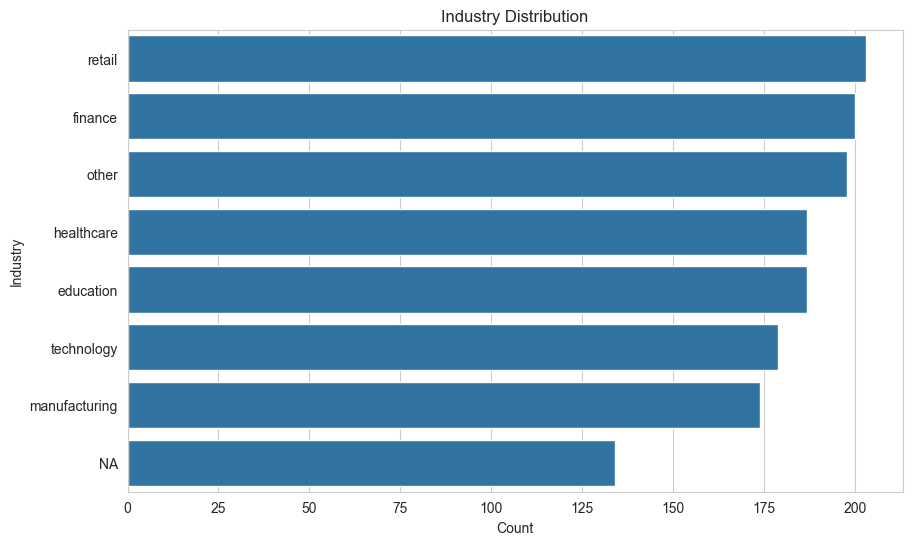

In [11]:
# Distribution of the industry feature
plt.figure(figsize=(10, 6))
sns.barplot(x=df.industry.value_counts().values, y=df.industry.value_counts().index)
plt.title("Industry Distribution")
plt.xlabel("Count")
plt.ylabel("Industry")
plt.show()

## Question 2

Create the [correlation matrix](https://www.google.com/search?q=correlation%20matrix) for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features.

What are the two features that have the biggest correlation?

- interaction_count and lead_score
- number_of_courses_viewed and lead_score
- number_of_courses_viewed and interaction_count
- annual_income and interaction_count

Only consider the pairs above when answering this question.
Split the data

- Split your data in train/val/test sets with 60%/20%/20% distribution.
- Use Scikit-Learn for that (the train_test_split function) and set the seed to 42.
- Make sure that the target value y is not in your dataframe.


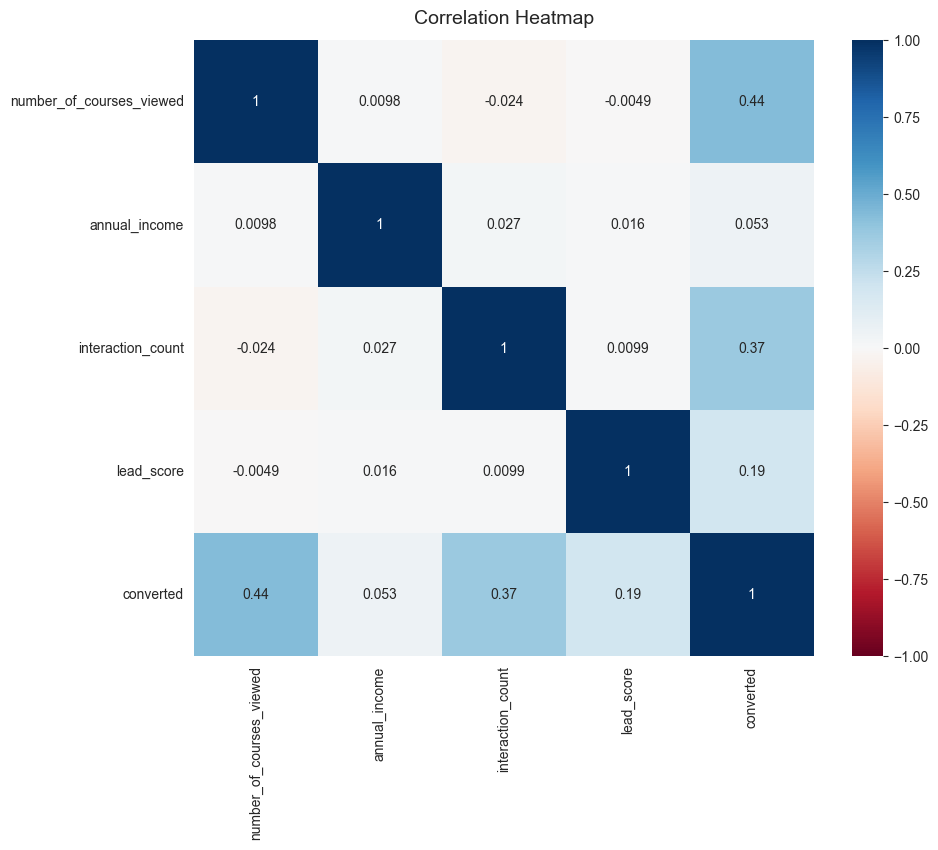

In [12]:
# Correlation heatmap
plt.figure(figsize=(10, 8))

heatmap = sns.heatmap(
    df[numerical_features].corr(method="pearson"),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap=sns.color_palette("RdBu", as_cmap=True),
)

heatmap.set_title("Correlation Heatmap", fontdict={"fontsize": 14}, pad=12);


From the options annual income with interaction count have the biggest correlation magnitude


In [13]:
# Train, test, validation split
full_train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_df, val_df = train_test_split(full_train_df, test_size=0.25, random_state=42)
len(train_df), len(val_df), len(test_df)

(876, 293, 293)

In [14]:
# Prepare data for modeling
target = "converted"
features = numerical_features + categorical_features
features.remove(target)

# Training set
X_train = train_df[features].reset_index(drop=True)
y_train = train_df[target].reset_index(drop=True)

# Validation set
X_val = val_df[features].reset_index(drop=True)
y_val = val_df[target].reset_index(drop=True)

# Test set
X_test = test_df[features].reset_index(drop=True)
y_test = test_df[target].reset_index(drop=True)

## Question 3

- Calculate the mutual information score between y and other categorical variables in the dataset. Use the training set only.
- Round the scores to 2 decimals using round(score, 2).

Which of these variables has the biggest mutual information score?

- industry
- location
- lead_source
- employment_status


In [15]:
def mutual_info_score_converted(series):
    return mutual_info_score(series, y_train)

In [16]:
mi = X_train[categorical_features].apply(mutual_info_score_converted)
mi.sort_values(ascending=False)

round(mi, 3)

lead_source          0.035
industry             0.012
employment_status    0.013
location             0.004
dtype: float64

In [17]:
print(
    f"The biggest mutual information score is {mi.max():.3f} for the feature {mi.idxmax()}"
)

The biggest mutual information score is 0.035 for the feature lead_source


## Question 4

- Now let's train a logistic regression.
- Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
- Fit the model on the training dataset.
  - To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
  - model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
- Calculate the accuracy on the validation dataset and round it to 2 decimal digits.

What accuracy did you get?

- 0.64
- 0.74
- 0.84
- 0.94


In [18]:
# One-hot encoding
dv = DictVectorizer(sparse=False)

X_train = dv.fit_transform(X_train.to_dict(orient="records"))
X_val = dv.transform(X_val.to_dict(orient="records"))
X_test = dv.transform(X_test.to_dict(orient="records"))

X_train.shape, X_val.shape, X_test.shape

((876, 31), (293, 31), (293, 31))

In [19]:
# Logistic Regression
model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1_000, random_state=42)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [20]:
model.intercept_

array([-0.06914728])

In [21]:
model.coef_.round(3)

array([[-0.   , -0.015,  0.034,  0.003,  0.012, -0.103, -0.025,  0.049,
        -0.02 , -0.013, -0.003, -0.009, -0.032, -0.016,  0.311,  0.051,
         0.02 , -0.012, -0.012, -0.115,  0.08 , -0.03 ,  0.004, -0.011,
        -0.011, -0.006,  0.008,  0.006, -0.033, -0.025,  0.454]])

In [22]:
y_pred = model.predict_proba(X_val)[:, 1]
converted_decision = y_pred >= 0.5

In [23]:
original_accuracy = (converted_decision == y_val).mean()
print(f"Original Model Accuracy (with all features): {original_accuracy:.4f}\n")

Original Model Accuracy (with all features): 0.6997



## Question 5

- Let's find the least useful feature using the feature elimination technique.
- Train a model using the same features and parameters as in Q4 (without rounding).
- Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
- For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

Which of following feature has the smallest difference?

- 'industry'
- 'employment_status'
- 'lead_score'

  Note: The difference doesn't have to be positive.


In [24]:
# Store the results in a dictionary
accuracy_differences = {}

for feature in features:
    # Logistic Regression Model
    iter_model = LogisticRegression(
        solver="liblinear", C=1.0, max_iter=1_000, random_state=42
    )

    # Features to keep
    features_to_keep = [f for f in features if f != feature]

    # Training and Validation Set
    X_train_iter = train_df[features_to_keep].reset_index(drop=True)
    X_val_iter = val_df[features_to_keep].reset_index(drop=True)

    dv_iter = DictVectorizer(sparse=False)

    # One-hot encoding
    X_train_iter = dv_iter.fit_transform(X_train_iter.to_dict(orient="records"))
    X_val_iter = dv_iter.transform(X_val_iter.to_dict(orient="records"))

    # Training model on subset of features
    iter_model.fit(X_train_iter, y_train)

    y_pred_iter = iter_model.predict_proba(X_val_iter)[:, 1]
    decision_iter = y_pred_iter >= 0.5
    iter_accuracy = (decision_iter == y_val).mean()

    # Calculate and store the difference
    diff = np.abs(original_accuracy - iter_accuracy)
    accuracy_differences[feature] = diff

    print(
        f"Model without {feature:<24}| Accuracy = {iter_accuracy:.4f}| Absolute Difference = {diff:.4f}"
    )

Model without number_of_courses_viewed| Accuracy = 0.5563| Absolute Difference = 0.1433
Model without annual_income           | Accuracy = 0.8532| Absolute Difference = 0.1536
Model without interaction_count       | Accuracy = 0.5563| Absolute Difference = 0.1433
Model without lead_score              | Accuracy = 0.7065| Absolute Difference = 0.0068
Model without lead_source             | Accuracy = 0.7031| Absolute Difference = 0.0034
Model without industry                | Accuracy = 0.6997| Absolute Difference = 0.0000
Model without employment_status       | Accuracy = 0.6962| Absolute Difference = 0.0034
Model without location                | Accuracy = 0.7099| Absolute Difference = 0.0102


In [25]:
# Least useful feature
least_useful_feat = min(accuracy_differences, key=accuracy_differences.get)
print(f"The least useful feature is: '{least_useful_feat}'")

The least useful feature is: 'industry'


## Question 6

- Now let's train a regularized logistic regression.
- Let's try the following values of the parameter C: [0.01, 0.1, 1, 10, 100].
- Train models using all the features as in Q4.
- Calculate the accuracy on the validation dataset and round it to 3 decimal digits.

Which of these C leads to the best accuracy on the validation set?

- 0.01
- 0.1
- 1
- 10
- 100


In [26]:
# Regularization values
reg_values = [0.01, 0.1, 1, 10, 100]

accuracy_reg_values = {}

for C in reg_values:
    # Logistic Regression
    model_reg = LogisticRegression(
        solver="liblinear", C=C, max_iter=1_000, random_state=42
    )
    # Train the model
    model_reg.fit(X_train, y_train)

    # Calculate predictions
    y_pred_reg = model_reg.predict_proba(X_val)[:, 1]
    decision_reg = y_pred_reg >= 0.5
    reg_accuracy = (decision_reg == y_val).mean()

    # Fill the accuracy_reg_values dictionary
    accuracy_reg_values[C] = reg_accuracy

    print(f"Regularization parameter: {C:>4}| Accuracy = {reg_accuracy:.3f}")

Regularization parameter: 0.01| Accuracy = 0.700
Regularization parameter:  0.1| Accuracy = 0.700
Regularization parameter:    1| Accuracy = 0.700
Regularization parameter:   10| Accuracy = 0.700
Regularization parameter:  100| Accuracy = 0.700


In [27]:
# Best regularization parameter
best_reg = max(accuracy_reg_values, key=accuracy_reg_values.get)
print(f"The Best Regularization parameter is: '{best_reg}'")


The Best Regularization parameter is: '0.01'
